### Feature selection

### Import libraries

In [41]:
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
import time
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sb
import statistics
from scipy.stats import kurtosis, skew
import pprint

### Load dataset

In [57]:
news_df = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv")
news_df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


### Feature Importance

In [58]:
# shredding the whitespaces in the dataset columns
columns = [col.strip() for col in news_df.columns]
news_df.columns = columns

In [59]:
# changing the continuous target class to binary
news_df.loc[news_df['shares'] < 1500, 'shares'] = 0
news_df.loc[news_df['shares'] >= 1500, 'shares'] = 1

In [60]:
# adding a new column for weekday in the news_df using temp variable
temp = news_df[['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday']]
temp['is_weekday'] = np.NaN

# changing the is_weekday as per weekday values
for index, row in temp.iterrows():
    if (row['weekday_is_monday'] == 1.0 or row['weekday_is_tuesday'] == 1.0 or row['weekday_is_wednesday'] == 1.0 or row['weekday_is_thursday'] == 1.0 or row['weekday_is_friday'] == 1.0):
        row['is_weekday'] = 1.0

# indices of the empty rows
# np.argwhere(np.isnan(temp['is_weekday']))

# total number of null/empty values in dataframe
# temp.isna().sum()

# fill the empty values with 0
temp['is_weekday'].fillna(0.0, inplace=True)

# assigning the temp variable to the news_df
news_df['is_weekday'] = temp['is_weekday']

# dropping the separated days column
news_df.drop(['weekday_is_monday','weekday_is_tuesday','weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday','weekday_is_sunday','weekday_is_saturday'], axis=1, inplace=True)

# news_df['is_weekday'].value_counts()

C:\Users\Admin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Admin\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [ ]:
# Feature Importance (Ref- https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e)
# dividing the features due to low computational power

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.08303756 0.14519048 0.14372903 0.00025858 0.14448454 0.11754733
 0.09553058 0.07698249 0.04712016 0.14611925]


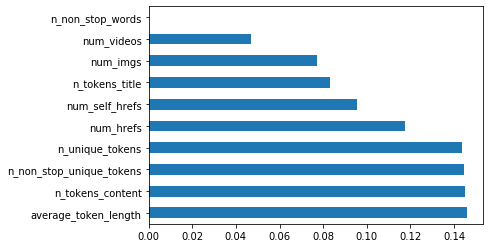

In [61]:
temp1 = news_df[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length']]
y = news_df['shares']
relation = ExtraTreesClassifier()
relation.fit(temp1,y)
# inbuilt class
print(relation.feature_importances_)
#plotting graph
features = pd.Series(relation.feature_importances_, index=temp1.columns)
features.nlargest(16).plot(kind='barh')
plt.show()

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.06491386 0.00165132 0.01451068 0.00543264 0.0093175  0.00782589
 0.0173198  0.01823093 0.12403299 0.1299808  0.06470471 0.01936722
 0.13277852 0.09007312 0.14727099 0.15258903]


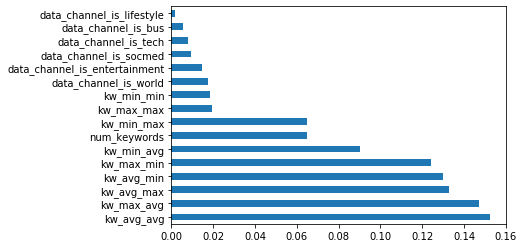

In [62]:
temp2 = news_df[['num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg']]
y = news_df['shares']
relation = ExtraTreesClassifier()
relation.fit(temp2,y)
# inbuilt class
print(relation.feature_importances_)
#plotting graph
features = pd.Series(relation.feature_importances_, index=temp2.columns)
features.nlargest(16).plot(kind='barh')
plt.show()

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.11051158 0.10120665 0.10928222 0.01956974 0.12783916 0.13337978
 0.14211878 0.12969855 0.12639354]


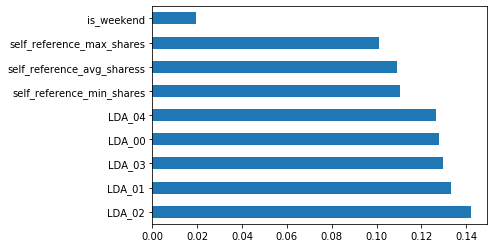

In [66]:
temp3 = news_df[['self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'is_weekend', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04']]
y = news_df['shares']
relation = ExtraTreesClassifier()
relation.fit(temp3,y)
# inbuilt class
print(relation.feature_importances_)
#plotting graph
features = pd.Series(relation.feature_importances_, index=temp3.columns)
features.nlargest(16).plot(kind='barh')
plt.show()

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.12524151 0.11839253 0.11385218 0.10488447 0.09081903 0.08966852
 0.11574411 0.07740404 0.05321291 0.11078071]


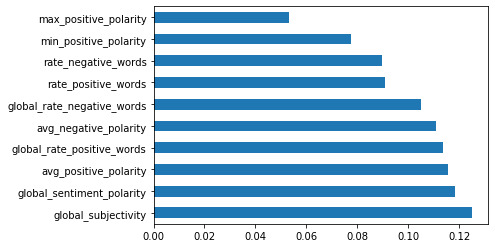

In [64]:
temp4 = news_df[['global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity']]
y = news_df['shares']
relation = ExtraTreesClassifier()
relation.fit(temp4,y)
# inbuilt class
print(relation.feature_importances_)
#plotting graph
features = pd.Series(relation.feature_importances_, index=temp4.columns)
features.nlargest(16).plot(kind='barh')
plt.show()

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.26993437 0.29178543 0.0917641  0.10602598 0.09114262 0.10114861
 0.04819889]


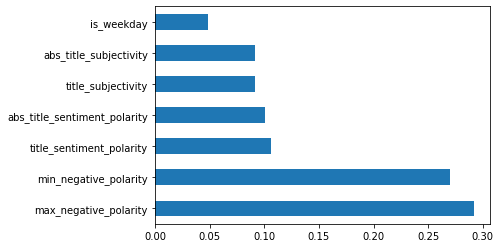

In [65]:
temp5 = news_df[['min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'is_weekday']]
y = news_df['shares']
relation = ExtraTreesClassifier()
relation.fit(temp5,y)
# inbuilt class
print(relation.feature_importances_)
#plotting graph
features = pd.Series(relation.feature_importances_, index=temp5.columns)
features.nlargest(16).plot(kind='barh')
plt.show()
# less important features as per Feature Importance- 'n_non_stop_words', 'data_channel_is_lifestyle',
# 'data_channel_is_entertainment', 'data_channel_is_bus','data_channel_is_socmed', 
# 'data_channel_is_tech', 'data_channel_is_world', 'is_weekend', 'is_weekday'

(11, 0)

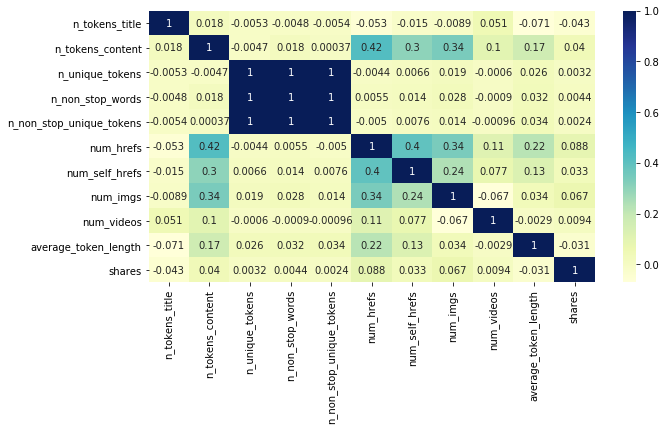

In [68]:
# Correlation matrix with Heatmap
# less important features as per Heatmap- 'n_non_stop_words', 'n_unique_tokens', 'num_videos', 'n_non_stop_unique_tokens'
# 'kw_min_max', 'data_channel_is_bus', 'self_reference_min_shares', 'self_reference_max_shares'
# 'avg_negative_polarity', 'min_positive_polarity', 'avg_positive_polarity', 'max_positive_polarity'
# 'min_negative_polarity', 'max_negative_polarity', 'abs_title_subjectivity'
temp1 = news_df[['n_tokens_title', 'n_tokens_content', 'n_unique_tokens',
       'n_non_stop_words', 'n_non_stop_unique_tokens', 'num_hrefs',
       'num_self_hrefs', 'num_imgs', 'num_videos', 'average_token_length', 'shares']]

matrix = temp1.corr()
features = matrix.index
plt.figure(figsize=(10,5))
# plotting a heat map
heat_map = sb.heatmap(temp1[features].corr(), annot=True, cmap="YlGnBu")
heat_map.set_ylim(11, 0)

(17, 0)

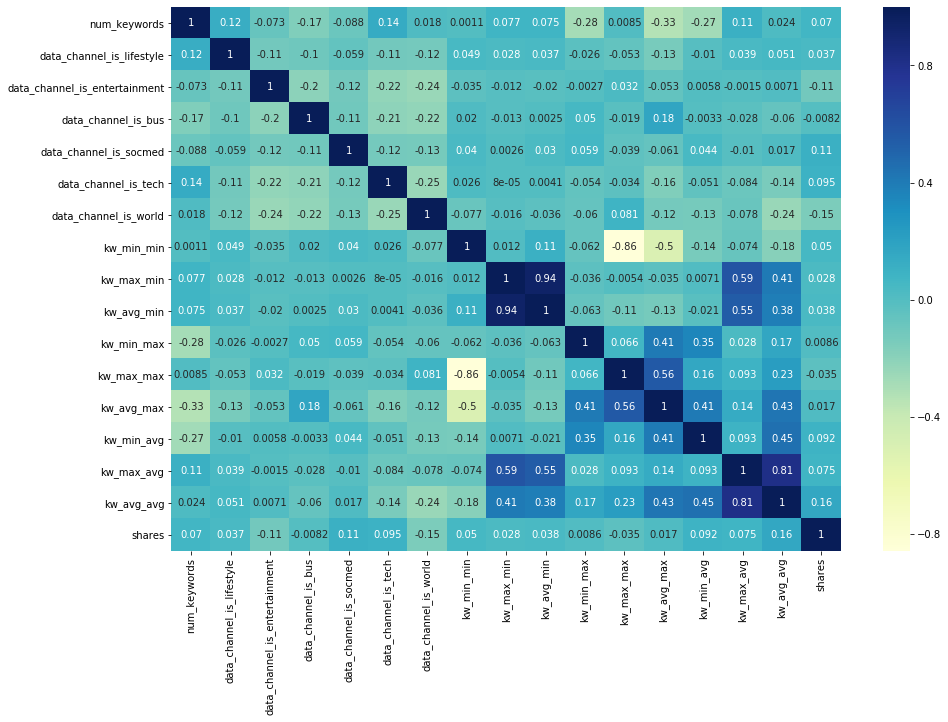

In [73]:
temp2 = news_df[['num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'shares']]

matrix = temp2.corr()
features = matrix.index
plt.figure(figsize=(15,10))
# plotting a heat map
heat_map = sb.heatmap(temp2[features].corr(), annot=True, cmap="YlGnBu")
heat_map.set_ylim(17, 0)

(10, 0)

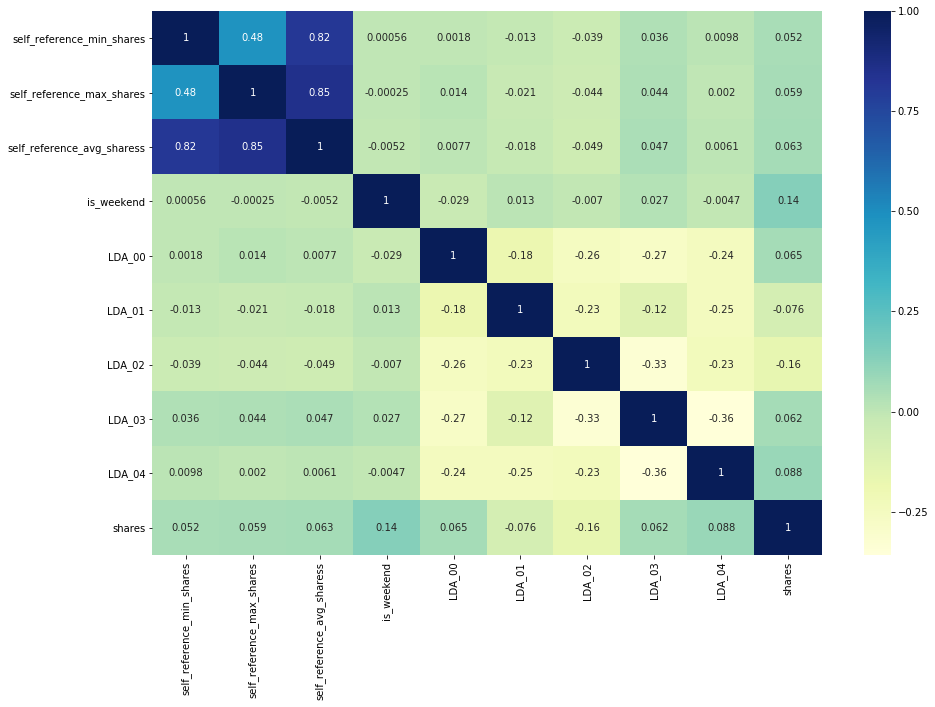

In [75]:
temp3 = news_df[['self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'is_weekend', 'LDA_00', 'LDA_01',
       'LDA_02', 'LDA_03', 'LDA_04', 'shares']]

matrix = temp3.corr()
features = matrix.index
plt.figure(figsize=(15,10))
# plotting a heat map
heat_map = sb.heatmap(temp3[features].corr(), annot=True, cmap="YlGnBu")
heat_map.set_ylim(10, 0)

(11, 0)

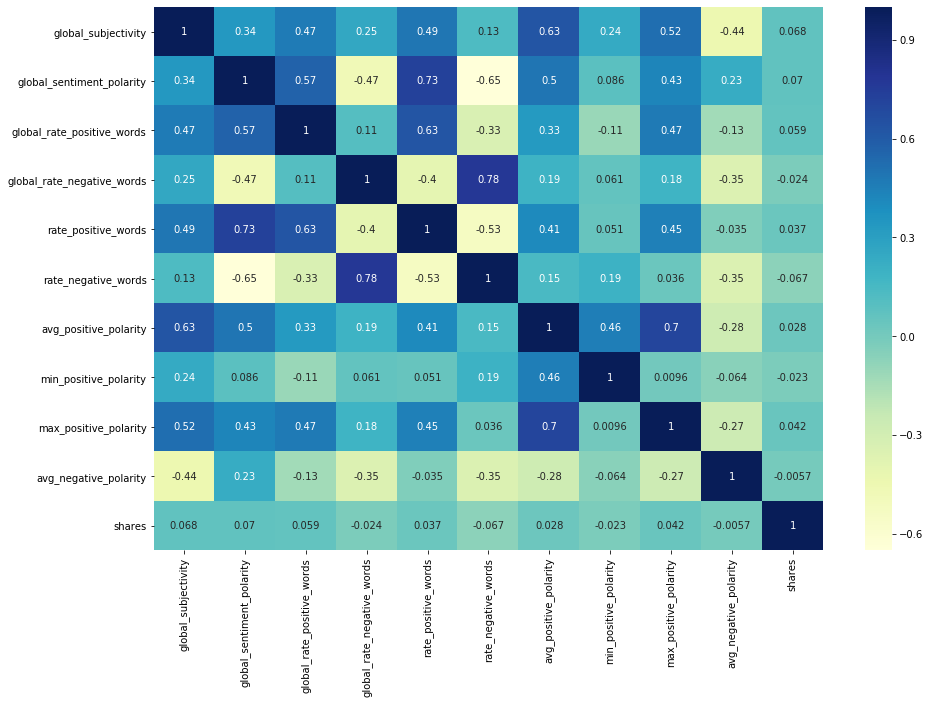

In [77]:
temp4 = news_df[['global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'rate_positive_words',
       'rate_negative_words', 'avg_positive_polarity', 'min_positive_polarity',
       'max_positive_polarity', 'avg_negative_polarity', 'shares']]
matrix = temp4.corr()
features = matrix.index
plt.figure(figsize=(15,10))
# plotting a heat map
heat_map = sb.heatmap(temp4[features].corr(), annot=True, cmap="YlGnBu")
heat_map.set_ylim(11, 0)

(8, 0)

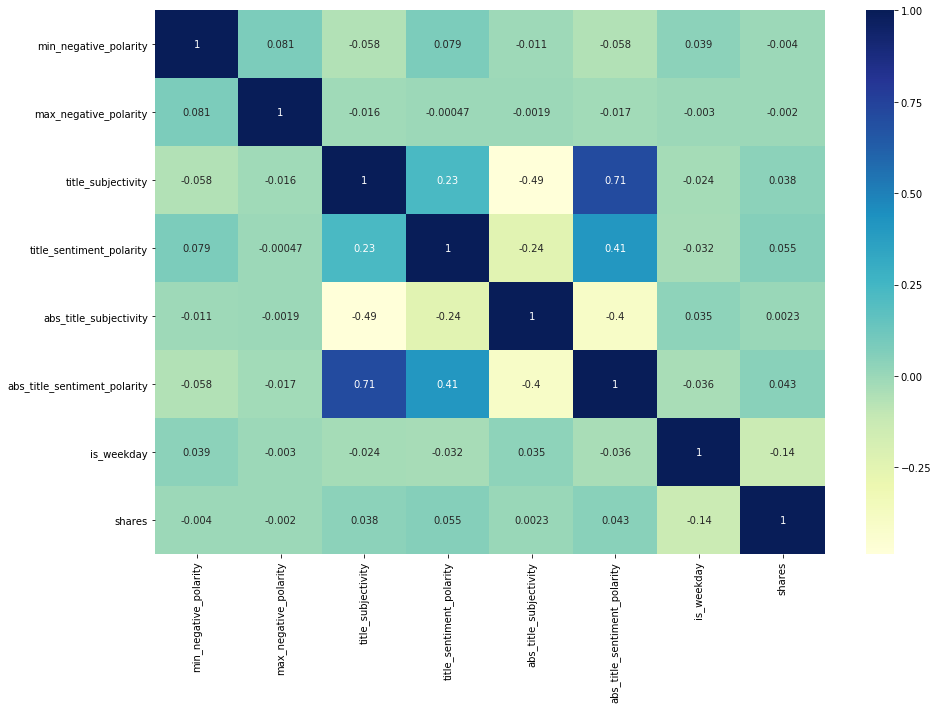

In [80]:
temp5 = news_df[['min_negative_polarity', 'max_negative_polarity', 'title_subjectivity',
       'title_sentiment_polarity', 'abs_title_subjectivity',
       'abs_title_sentiment_polarity', 'is_weekday', 'shares']]
matrix = temp5.corr()
features = matrix.index
plt.figure(figsize=(15,10))
# plotting a heat map
heat_map = sb.heatmap(temp5[features].corr(), annot=True, cmap="YlGnBu")
heat_map.set_ylim(8, 0)

In [13]:
# check the null and NA value percentage for any features
for col in news_df.columns:
    print(news_df[col].isnull().sum()/len(news_df[col])*100)
for col in news_df.columns:
    print(news_df[col].isna().sum()/len(news_df[col])*100)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [ ]:
# removing the 'url' and 'timedelta' column as they are non-predictive
news_df.drop(['url', 'timedelta'], axis=1, inplace=True)

In [52]:
# check the variance of all the features
for col in news_df.columns:
    var = statistics.variance(news_df[col])
    print(col + " -> " + str(var))

n_tokens_title -> 4.469151626862218
n_tokens_content -> 221942.2840450277
num_hrefs -> 128.41461781021283
num_self_hrefs -> 14.862113250758988
num_imgs -> 69.04668541671354
average_token_length -> 0.7130207585328795
num_keywords -> 3.6447788306366333
kw_min_min -> 4848.784648149195
kw_max_min -> 14884093.603388894
kw_avg_min -> 385372.6347484558
kw_max_max -> 46011163591.25111
kw_avg_max -> 18252617221.39656
kw_min_avg -> 1293808.3148620313
kw_max_avg -> 37196239.144845486
kw_avg_avg -> 1737520.4693583355
self_reference_avg_sharess -> 586188608.4150863
weekday_is_monday -> 0.1397930590402299
weekday_is_tuesday -> 0.15166453575662533
weekday_is_wednesday -> 0.15237518093358157
weekday_is_thursday -> 0.14970895728179878
weekday_is_friday -> 0.1231281304245985
weekday_is_saturday -> 0.05804855645179285
weekday_is_sunday -> 0.0642746265998652
is_weekend -> 0.11377923967780108
LDA_00 -> 0.06915569764384502
LDA_01 -> 0.048271310348938286
LDA_02 -> 0.07960591607833598
LDA_03 -> 0.087137569131

In [31]:
# check skewness and kurtosis
for col in news_df.columns:
    print(col + ' Kurtosis (should be 0): {}'.format(kurtosis(news_df[col])))
    print(col + ' Skewness (should be 0): {}'.format(skew(news_df[col])))
    print('\n')

n_tokens_title Kurtosis (should be 0): -0.0009009193260514081
n_tokens_title Skewness (should be 0): 0.16531412149825878


n_tokens_content Kurtosis (should be 0): 19.47580370021696
n_tokens_content Skewness (should be 0): 2.9453104924305262


n_unique_tokens Kurtosis (should be 0): 39518.847181370744
n_unique_tokens Skewness (should be 0): 198.64759905589614


n_non_stop_words Kurtosis (should be 0): 39555.30553163253
n_non_stop_words Skewness (should be 0): 198.78492363836094


n_non_stop_unique_tokens Kurtosis (should be 0): 39462.715968413024
n_non_stop_unique_tokens Skewness (should be 0): 198.43578588161438


num_hrefs Kurtosis (should be 0): 35.5017035120209
num_hrefs Skewness (should be 0): 4.01334296901664


num_self_hrefs Kurtosis (should be 0): 56.16422073379269
num_self_hrefs Skewness (should be 0): 5.172555383625405


num_imgs Kurtosis (should be 0): 24.522501415540955
num_imgs Skewness (should be 0): 3.9464465167353917


num_videos Kurtosis (should be 0): 74.0659203093924

In [50]:
# news_df.isnull().sum().tolist()

# drop unimportant columns
news_df = news_df.drop(['n_non_stop_words', 'n_unique_tokens', 'num_videos', 'n_non_stop_unique_tokens',
'kw_min_max', 'data_channel_is_lifestyle', 'data_channel_is_socmed', 'data_channel_is_tech', 'data_channel_is_world',
'data_channel_is_entertainment', 'data_channel_is_bus', 'self_reference_min_shares', 'self_reference_max_shares',
'avg_negative_polarity', 'min_positive_polarity', 'avg_positive_polarity', 'max_positive_polarity',
'min_negative_polarity', 'max_negative_polarity', 'abs_title_subjectivity'], axis=1)

In [53]:
# putting the dataframe in X and splitting in test-train
X = news_df.copy(deep=True)
y = news_df['shares']
# scaling the values between the range 0 to 1
scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
X = scaler.fit_transform(X)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [56]:
# Not used
# # Recursive Feature Elimination (RFE)
# model = RandomForestClassifier(n_estimators=200)
# rfe = RFE(model, 20)
# start = time.process_time()
# RFE_X_Train = rfe.fit_transform(X_train,y_train)
# RFE_X_Test = rfe.transform(X_test)
# rfe = rfe.fit(RFE_X_Train,y_train)
# print(time.process_time() - start)
# print("Overall Accuracy using RFE: ", rfe.score(RFE_X_Test,y_test))

237.84375
Overall Accuracy using RFE:  1.0
